# Fitts Law Analysis

In [26]:
import json
import pandas as pd
import numpy as np

f_mouse = open('./input/interaction_data_mouse.json', 'r')
f_track = open('./input/interaction_data_trackpad.json', 'r')

mouse_data = json.load(f_mouse)
mouse_df = pd.json_normalize(mouse_data, record_path=['logs'])
mouse_df['group'] = 'mouse'

tp_data = json.load(f_track)
tp_df = pd.json_normalize(tp_data, record_path=['logs'])
tp_df['group'] = 'trackpad'

print(mouse_df.shape)
print(tp_df.shape)

(67, 8)
(40, 8)


In [27]:
all_data = pd.concat([mouse_df, tp_df])

print(all_data.shape)
all_data.head()

(107, 8)


,clickNum,clickTime,timeDiff,buttonHeight,buttonWidth,buttonX,buttonY,group
0,1,1740538904965,0,50,50,30,60,mouse
1,2,1740538905458,493,95,209,110,71,mouse
2,3,1740538905848,390,203,53,269,203,mouse
3,4,1740538906439,591,110,64,36,384,mouse
4,5,1740538906837,398,171,146,301,286,mouse


## Fitts's law
$MT = a + b * log2(2D/W)$

MT is the average time to complete the movement.

- a and b are constants that depend on the choice of input device and are usually determined empirically by regression analysis. 
- a defines the intersection on the y axis and is often interpreted as a delay. 
- The b parameter is a slope and describes an acceleration. 
- Both parameters show the linear dependency in Fitts's law.[10]

- ID is the index of difficulty.
- D is the distance from the starting point to the center of the target.
- W is the width of the target measured along the axis of motion. 
- W can also be thought of as the allowed error tolerance in the final position, since the final point of the motion must fall within ±W⁄2 of the target's center.

Imagine a mouse cursor on a screen needing to click a button 100 pixels away (D=100) with a width of 50 pixels (W=50). 

W = buttonWidth 

$\mathrm{ID}=\log _2\left(\frac{2 D}{W}\right)$

### Distance Formula

Regular Formula:

$d = \sqrt {\left( {x_1 - x_2 } \right)^2 + \left( {y_1 - y_2 } \right)^2 }$


Project Formula:

$D = \sqrt {\left( {buttonX_1 - buttonX_2 } \right)^2 + \left( {buttonY_1 - buttonY_2 } \right)^2 }$

Where the first sample is the initial starting point, then X1 is the previous button location

## Analysis

In [28]:
analysis = all_data.copy()
analysis['w'] = analysis['buttonWidth']

# fields for distance calculation
analysis['x1'] = analysis['buttonX'].shift(1)
analysis['y1'] = analysis['buttonY'].shift(1)
analysis['(x1-x2)^2'] = analysis.apply(
                    lambda row: (row['x1'] - row['buttonX'])**2 if pd.notna(row['x1']) else row['buttonX'], axis=1
                )
analysis['(y1-y2)^2'] = analysis.apply(
                    lambda row: (row['y1'] - row['buttonY'])**2 if pd.notna(row['y1']) else row['buttonY'], axis=1
                )
analysis['d'] = np.sqrt(analysis['(x1-x2)^2'] + analysis['(y1-y2)^2'])

analysis.head()

,clickNum,clickTime,timeDiff,buttonHeight,buttonWidth,buttonX,buttonY,group,w,x1,y1,(x1-x2)^2,(y1-y2)^2,d
0,1,1740538904965,0,50,50,30,60,mouse,50,NaN,NaN,30.0,60.0,9.486833
1,2,1740538905458,493,95,209,110,71,mouse,209,30.0,60.0,6400.0,121.0,80.752709
2,3,1740538905848,390,203,53,269,203,mouse,53,110.0,71.0,25281.0,17424.0,206.651881
3,4,1740538906439,591,110,64,36,384,mouse,64,269.0,203.0,54289.0,32761.0,295.042370
4,5,1740538906837,398,171,146,301,286,mouse,146,36.0,384.0,70225.0,9604.0,282.540263


In [30]:
final_analysis = analysis.copy()
# excluding first clicks for both runs
# need to do this to not get 'weird' values
final_analysis = final_analysis[final_analysis['clickNum'] != 1].reset_index(drop=True)

final_analysis.head()

,clickNum,clickTime,timeDiff,buttonHeight,buttonWidth,buttonX,buttonY,group,w,x1,y1,(x1-x2)^2,(y1-y2)^2,d
0,2,1740538905458,493,95,209,110,71,mouse,209,30.0,60.0,6400.0,121.0,80.752709
1,3,1740538905848,390,203,53,269,203,mouse,53,110.0,71.0,25281.0,17424.0,206.651881
2,4,1740538906439,591,110,64,36,384,mouse,64,269.0,203.0,54289.0,32761.0,295.042370
3,5,1740538906837,398,171,146,301,286,mouse,146,36.0,384.0,70225.0,9604.0,282.540263
4,6,1740538907311,473,227,34,516,45,mouse,34,301.0,286.0,46225.0,58081.0,322.964394


In [32]:
final_df = final_analysis.copy()
final_df = final_df[['group', 'timeDiff', 'w', 'd']]
final_df['ID'] = np.log2(((2*final_df['d'])/final_df['w']))

final_df.head()

,group,timeDiff,w,d,ID
0,mouse,493,209,80.752709,-0.371920
1,mouse,390,53,206.651881,2.963138
2,mouse,591,64,295.042370,3.204778
3,mouse,398,146,282.540263,1.952488
4,mouse,473,34,322.964394,4.247768


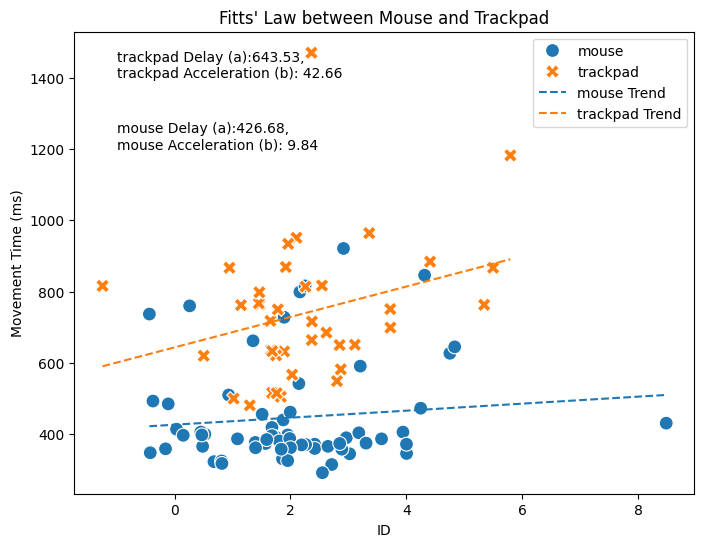

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
plt.figure(figsize=(8,6))

sns.scatterplot(data=final_df, x='ID', y='timeDiff', hue='group', style='group', s=100)

for group in final_df['group'].unique():
    group_subset = final_df[final_df['group'] == group]
    
    # Fit a OLS model for line
    X = sm.add_constant(group_subset['ID'])
    model = sm.OLS(group_subset['timeDiff'], X).fit()
    # getting intercept and slope, our a and b values
    slope, intercept = model.params['ID'], model.params['const']
    
    # This is how were getting the lines
    x_vals = np.linspace(group_subset['ID'].min(), group_subset['ID'].max(), 100)
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, label=f'{group} Trend', linestyle='--')
    
    # Adding text to show a (delay) and b (acceleration)
    if group == 'trackpad':
        plt.text(-1, 1400, 
                f'{group} Delay (a):{intercept:.2f},\n' + f'{group} Acceleration (b): {slope:.2f}', 
                fontsize=10, color='black')
    else:
        plt.text(-1, 1200, 
                f'{group} Delay (a):{intercept:.2f},\n' + f'{group} Acceleration (b): {slope:.2f}', 
                fontsize=10, color='black')
                
plt.xlabel("ID")
plt.ylabel("Movement Time (ms)")
plt.title("Fitts' Law between Mouse and Trackpad")
plt.legend()
plt.show()